<a href="https://colab.research.google.com/github/cmreyesvalencia-png/colab-git-assignment2-CR/blob/main/Lesson_15_assigment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 15: Loan Default Prediction**
- **Course:** Data Analytics and Business Intelligence Analyst
- **Institution:** Willis College
- **Student Name:** Carlos Reyes
- **Instructor:** Ratinder Rajpal
- **Date:** 2025 Nov, 16

# **Step1: Data Analysis and Cleaning**
1. Find and download a publicly available dataset related to loan default prediction (e.g., from Kaggle or UCI Machine Learning Repository).
2. Perform exploratory data analysis (EDA) to understand the dataset.
     - Display summary statistics.
     - Visualize distributions and relationships between features.
3. Clean the dataset:
      - Handle missing values.
      - Encode categorical variables.
      - Normalize numerical features.


In [4]:
!pip install lime shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings('ignore')

# Task 1: Data Collection and Loading
print("=== TASK 1: DATA COLLECTION AND LOADING ===")

# Load the dataset directly from GitHub
url = 'https://raw.githubusercontent.com/cmreyesvalencia-png/colab-git-assignment2-CR/deb226fc4e99bf0623d117b6a3741bb5a677ffd6/bank-loan.csv'
data = pd.read_csv(url)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6f709241c8091beac830562a16b89032203f41336486294b621efaa5b89ce3e6
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
=== TASK 1: DATA COLLECTION AND LOADING ===


In [5]:
# Display data overview
print("Dataset Shape:", data.shape)
print("\nFirst 10 rows of the dataset:")
print(data.head(10))
print("\nDataset Info:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

Dataset Shape: (850, 9)

First 10 rows of the dataset:
   age  ed  employ  address  income  debtinc   creddebt    othdebt  default
0   41   3      17       12     176      9.3  11.359392   5.008608      1.0
1   27   1      10        6      31     17.3   1.362202   4.000798      0.0
2   40   1      15       14      55      5.5   0.856075   2.168925      0.0
3   41   1      15       14     120      2.9   2.658720   0.821280      0.0
4   24   2       2        0      28     17.3   1.787436   3.056564      1.0
5   41   2       5        5      25     10.2   0.392700   2.157300      0.0
6   39   1      20        9      67     30.6   3.833874  16.668126      0.0
7   43   1      12       11      38      3.6   0.128592   1.239408      0.0
8   24   1       3        4      19     24.4   1.358348   3.277652      1.0
9   36   1       0       13      25     19.7   2.777700   2.147300      0.0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 

In [18]:
# Task 2: Exploratory Data Analysis (EDA)
print("\n=== TASK 2: EXPLORATORY DATA ANALYSIS (EDA) ===")

# Check for missing values
print("Missing Values:")
print(data.isnull().sum())


=== TASK 2: EXPLORATORY DATA ANALYSIS (EDA) ===
Missing Values:
age            0
ed             0
employ         0
address        0
income         0
debtinc        0
creddebt       0
othdebt        0
default      150
age_group      2
dtype: int64


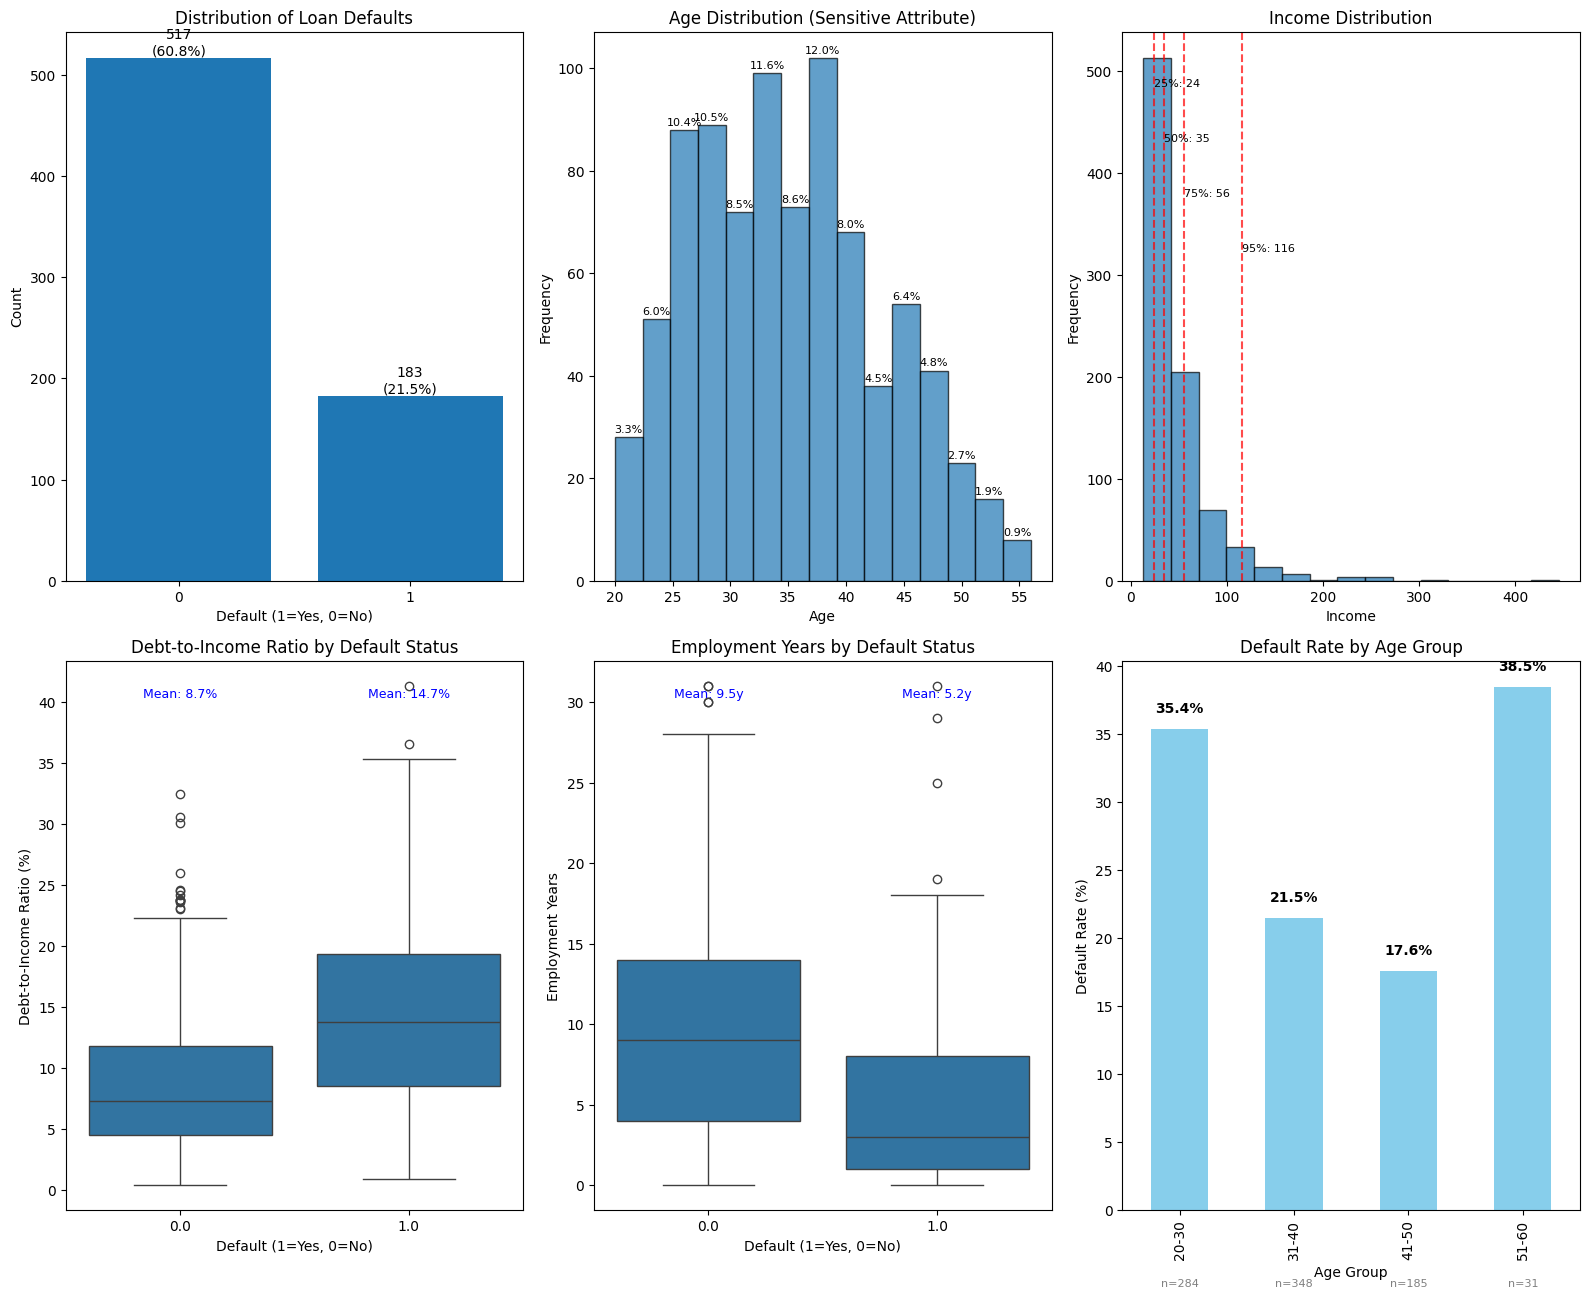

In [28]:
# Create age groups for analysis (for EDA only - will be excluded from modeling)
data['age_group'] = pd.cut(data['age'], bins=[20, 30, 40, 50, 60], labels=['20-30', '31-40', '41-50', '51-60'])

# Visualize the distribution of the target variable
plt.figure(figsize=(16, 13))


# Plot 1: Distribution of Loan Defaults with percentages
plt.subplot(2, 3, 1)
default_counts = data['default'].value_counts()
default_percentages = (default_counts / len(data) * 100).round(1)
bars = plt.bar(default_counts.index, default_counts.values)
plt.title('Distribution of Loan Defaults')
plt.xlabel('Default (1=Yes, 0=No)')
plt.ylabel('Count')
# Add percentage labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{default_counts.values[i]}\n({default_percentages.values[i]}%)',
             ha='center', va='bottom')
plt.xticks([0, 1])

# Plot 2: Age Distribution with percentages
plt.subplot(2, 3, 2)
age_counts, age_bins, _ = plt.hist(data['age'], bins=15, edgecolor='black', alpha=0.7)
plt.title('Age Distribution (Sensitive Attribute)')
plt.xlabel('Age')
plt.ylabel('Frequency')
# Add percentage labels
total = len(data)
for i, count in enumerate(age_counts):
    if count > 0:  # Only label non-zero bins
        percentage = (count / total * 100)
        plt.text(age_bins[i] + (age_bins[i+1] - age_bins[i])/2, count + 0.5,
                f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8)

# Plot 3: Income Distribution with percentiles
plt.subplot(2, 3, 3)
income_counts, income_bins, _ = plt.hist(data['income'], bins=15, edgecolor='black', alpha=0.7)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
# Add important percentiles
percentiles = [25, 50, 75, 95]
percentile_values = np.percentile(data['income'], percentiles)
for i, (p, p_val) in enumerate(zip(percentiles, percentile_values)):
    plt.axvline(p_val, color='red', linestyle='--', alpha=0.7)
    plt.text(p_val, plt.ylim()[1] * 0.9 - i * plt.ylim()[1] * 0.1,
             f'{p}%: {p_val:.0f}', fontsize=8)

# Plot 4: Debt-to-Income ratio by default status
plt.subplot(2, 3, 4)
sns.boxplot(x='default', y='debtinc', data=data)
plt.title('Debt-to-Income Ratio by Default Status')
plt.xlabel('Default (1=Yes, 0=No)')
plt.ylabel('Debt-to-Income Ratio (%)')
# Add mean values
default_0_mean = data[data['default'] == 0]['debtinc'].mean()
default_1_mean = data[data['default'] == 1]['debtinc'].mean()
plt.text(0, plt.ylim()[1] * 0.95, f'Mean: {default_0_mean:.1f}%',
         ha='center', va='top', fontsize=9, color='blue')
plt.text(1, plt.ylim()[1] * 0.95, f'Mean: {default_1_mean:.1f}%',
         ha='center', va='top', fontsize=9, color='blue')

# Plot 5: Employment Years by Default Status
plt.subplot(2, 3, 5)
sns.boxplot(x='default', y='employ', data=data)
plt.title('Employment Years by Default Status')
plt.xlabel('Default (1=Yes, 0=No)')
plt.ylabel('Employment Years')
# Add mean values
employ_0_mean = data[data['default'] == 0]['employ'].mean()
employ_1_mean = data[data['default'] == 1]['employ'].mean()
plt.text(0, plt.ylim()[1] * 0.95, f'Mean: {employ_0_mean:.1f}y',
         ha='center', va='top', fontsize=9, color='blue')
plt.text(1, plt.ylim()[1] * 0.95, f'Mean: {employ_1_mean:.1f}y',
         ha='center', va='top', fontsize=9, color='blue')

# Plot 6: Default Rate by Age Group with percentages
plt.subplot(2, 3, 6)
age_group_counts = data['age_group'].value_counts().sort_index()
age_group_default = data.groupby('age_group')['default'].mean() * 100
age_group_default.plot(kind='bar', color='skyblue')
plt.title('Default Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Default Rate (%)')
# Add percentage labels and count labels
for i, (age_group, default_rate) in enumerate(age_group_default.items()):
    count = age_group_counts[age_group]
    plt.text(i, default_rate + 1, f'{default_rate:.1f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(i, -5, f'n={count}',
             ha='center', va='top', fontsize=8, color='gray')

plt.tight_layout()
plt.show()



=== CORRELATION HEATMAP (NUMERIC COLUMNS ONLY) ===
Numeric columns used for correlation: ['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt', 'default']


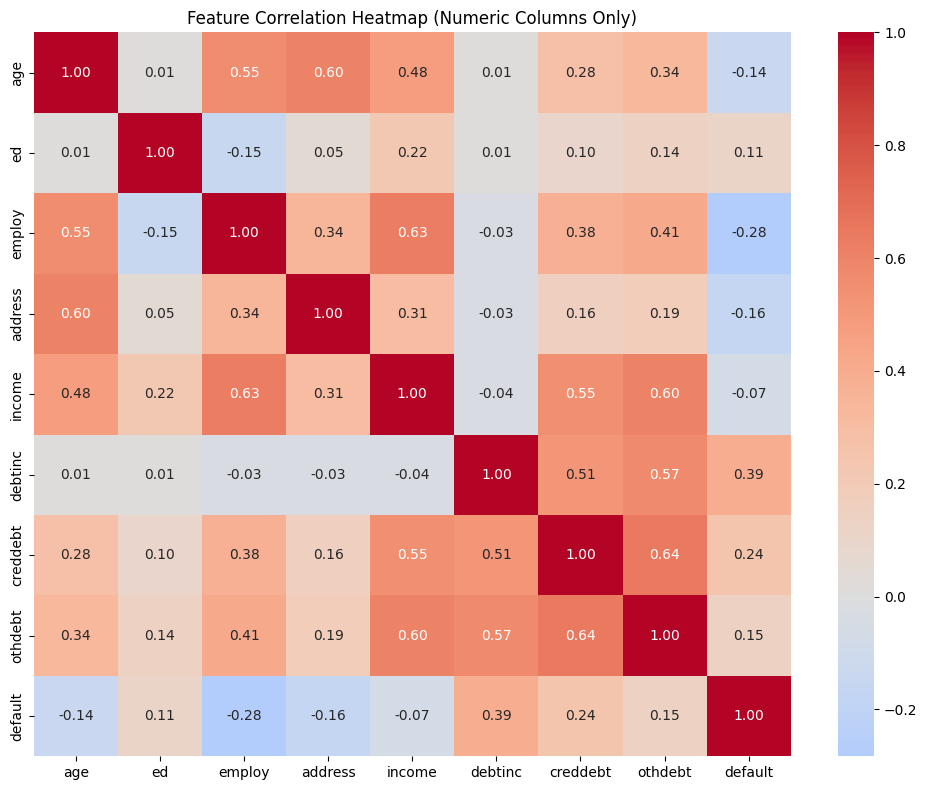


Top correlations with 'default' target variable:
debtinc: 0.390
creddebt: 0.245
othdebt: 0.146
ed: 0.115
income: -0.071
age: -0.138
address: -0.164
employ: -0.283


In [29]:
# Correlation heatmap with only numeric columns
print("\n=== CORRELATION HEATMAP (NUMERIC COLUMNS ONLY) ===")
# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=[np.number])
print("Numeric columns used for correlation:", list(numeric_data.columns))

plt.figure(figsize=(10, 8))
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap (Numeric Columns Only)')
plt.tight_layout()
plt.show()

# Display top correlations with the target variable
print("\nTop correlations with 'default' target variable:")
default_correlations = correlation_matrix['default'].sort_values(ascending=False)
for feature, corr in default_correlations.items():
    if feature != 'default':
        print(f"{feature}: {corr:.3f}")

In [30]:
# Task 3: Data Cleaning and Preprocessing
print("\n=== TASK 3: DATA CLEANING AND PREPROCESSING ===")

# Check for missing values again and handle them
print("Missing values before cleaning:")
print(data.isnull().sum())

# === CRITICAL UPDATE: Drop rows where 'default' is NaN before encoding ===
print("\n=== HANDLING MISSING TARGET VALUES ===")
initial_shape = data.shape
print(f"Initial dataset shape: {initial_shape}")

# Drop rows where the target variable 'default' is NaN
data = data.dropna(subset=['default'])
after_drop_shape = data.shape
print(f"Dataset shape after dropping rows with NaN in 'default': {after_drop_shape}")
print(f"Rows removed: {initial_shape[0] - after_drop_shape[0]}")

# Verify no missing values in target variable
print("\nMissing values after cleaning target variable:")
print(data.isnull().sum())


=== TASK 3: DATA CLEANING AND PREPROCESSING ===
Missing values before cleaning:
age            0
ed             0
employ         0
address        0
income         0
debtinc        0
creddebt       0
othdebt        0
default      150
age_group      2
dtype: int64

=== HANDLING MISSING TARGET VALUES ===
Initial dataset shape: (850, 10)
Dataset shape after dropping rows with NaN in 'default': (700, 10)
Rows removed: 150

Missing values after cleaning target variable:
age          0
ed           0
employ       0
address      0
income       0
debtinc      0
creddebt     0
othdebt      0
default      0
age_group    2
dtype: int64


In [32]:
# Handle missing values in feature columns (if any)
print("\n=== HANDLING MISSING FEATURE VALUES ===")
for column in data.columns:
    if data[column].isnull().sum() > 0 and column != 'default':
        if pd.api.types.is_numeric_dtype(data[column]):
            print(f"Filling missing values in {column} with median (numeric)")
            data[column].fillna(data[column].median(), inplace=True)
        else:
            print(f"Filling missing values in {column} with mode (categorical)")
            data[column].fillna(data[column].mode()[0], inplace=True)

print("\nFinal missing values check:")
print(data.isnull().sum())


=== HANDLING MISSING FEATURE VALUES ===
Filling missing values in age_group with mode (categorical)

Final missing values check:
age          0
ed           0
employ       0
address      0
income       0
debtinc      0
creddebt     0
othdebt      0
default      0
age_group    0
dtype: int64


In [62]:
# The 'ed' feature is categorical (ordinal)
print("\nUnique values in 'ed' feature:", sorted(data['ed'].unique()))

# Prepare features for modeling - exclude 'age_group' as it's for EDA only
print("\n=== PREPARING FEATURES FOR MODEL TRAINING ===")
print("Excluding 'age_group' column as it was created only for EDA and fairness analysis")

features_to_exclude = ['default', 'age_group']
X = data.drop(features_to_exclude, axis=1)
y = data['default']

print(f"Features used for modeling: {list(X.columns)}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target value counts:\n{y.value_counts()}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts()}")
print(f"Testing target distribution:\n{y_test.value_counts()}")


Unique values in 'ed' feature: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

=== PREPARING FEATURES FOR MODEL TRAINING ===
Excluding 'age_group' column as it was created only for EDA and fairness analysis
Features used for modeling: ['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt']
Features shape: (700, 8)
Target shape: (700,)
Target value counts:
default
0.0    517
1.0    183
Name: count, dtype: int64

Training set size: (560, 8)
Testing set size: (140, 8)
Training target distribution:
default
0.0    414
1.0    146
Name: count, dtype: int64
Testing target distribution:
default
0.0    103
1.0     37
Name: count, dtype: int64


# **Step2: Feature Engineering**
1. Create new features based on existing data to enhance prediction accuracy.
2. Scale numerical features to ensure consistency.


In [63]:
# Task 4: Feature Engineering
print("\n=== TASK 4: FEATURE ENGINEERING ===")

print("BEFORE Feature Engineering:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Original features: {list(X_train.columns)}")

# Create new features that might be predictive
# 1. Total debt - sum of credit debt and other debt
X_train['total_debt'] = X_train['creddebt'] + X_train['othdebt']
X_test['total_debt'] = X_test['creddebt'] + X_test['othdebt']

# 2. Employment stability - measures career consistency
# Calculated as employment years divided by (age - 22) assuming college graduation at 22
X_train['employment_stability'] = X_train['employ'] / (X_train['age'] - 22)
X_test['employment_stability'] = X_test['employ'] / (X_test['age'] - 22)

# Handle cases where age <= 22 (set to 0 employment stability)
X_train.loc[X_train['age'] <= 22, 'employment_stability'] = 0
X_test.loc[X_test['age'] <= 22, 'employment_stability'] = 0

# 3. Credit debt ratio - proportion of credit debt to total debt
# Uses proper zero debt handling without mathematical bias
X_train['creddebt_ratio'] = np.where(
    X_train['total_debt'] > 0,
    X_train['creddebt'] / X_train['total_debt'],
    0
)
X_test['creddebt_ratio'] = np.where(
    X_test['total_debt'] > 0,
    X_test['creddebt'] / X_test['total_debt'],
    0
)

print("\nAFTER Feature Engineering:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"All features including new ones: {list(X_train.columns)}")

print("\nNew features created and ADDED as columns:")
print("- total_debt: Sum of creddebt and othdebt - measures total debt burden")
print("- employment_stability: Employment years divided by (age - 22) - measures career consistency")
print("- creddebt_ratio: Proportion of credit debt to total debt - identifies risky debt composition")


=== TASK 4: FEATURE ENGINEERING ===
BEFORE Feature Engineering:
X_train shape: (560, 8)
X_test shape: (140, 8)
Original features: ['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt']

AFTER Feature Engineering:
X_train shape: (560, 11)
X_test shape: (140, 11)
All features including new ones: ['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt', 'total_debt', 'employment_stability', 'creddebt_ratio']

New features created and ADDED as columns:
- total_debt: Sum of creddebt and othdebt - measures total debt burden
- employment_stability: Employment years divided by (age - 22) - measures career consistency
- creddebt_ratio: Proportion of credit debt to total debt - identifies risky debt composition


In [64]:
# Scale numerical features including the new engineered features
scaler = MinMaxScaler()

# Define numerical features - includes all original and new engineered features
numerical_features = ['age', 'ed', 'employ', 'address', 'income', 'debtinc',
                     'creddebt', 'othdebt', 'total_debt', 'employment_stability',
                     'creddebt_ratio']

print(f"\nScaling {len(numerical_features)} numerical features using MinMaxScaler...")
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("✓ All features scaled successfully")


Scaling 11 numerical features using MinMaxScaler...
✓ All features scaled successfully


# **Step3: Model Building and Evaluation**
1. Split the data into training and testing sets.
2. Train a Random Forest classifier or another algorithm of your choice.
3. Evaluate the model using:
     - Accuracy
     - Confusion Matrix
     - Classification Report (Precision, Recall, F1-Score)
4. Analyze feature importance to determine which factors impact loan defaults.


In [69]:
# Task 5: Model Building and Evaluation
print("\n=== TASK 5: MODEL BUILDING AND EVALUATION ===")

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate the model
print("Model Evaluation Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


=== TASK 5: MODEL BUILDING AND EVALUATION ===
Model Evaluation Results:
Accuracy: 0.8071428571428572

Confusion Matrix:
[[92 11]
 [16 21]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       103
         1.0       0.66      0.57      0.61        37

    accuracy                           0.81       140
   macro avg       0.75      0.73      0.74       140
weighted avg       0.80      0.81      0.80       140




=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 Most Important Features:
                 feature  importance
5                debtinc    0.139446
2                 employ    0.111265
6               creddebt    0.107638
9   employment_stability    0.103588
8             total_debt    0.096144
10        creddebt_ratio    0.094467
7                othdebt    0.087967
0                    age    0.078046
4                 income    0.077171
3                address    0.076270

=== ENGINEERED FEATURES IMPORTANCE ===
Importance of engineered features:
- employment_stability: 10.36% importance
- total_debt: 9.61% importance
- creddebt_ratio: 9.45% importance


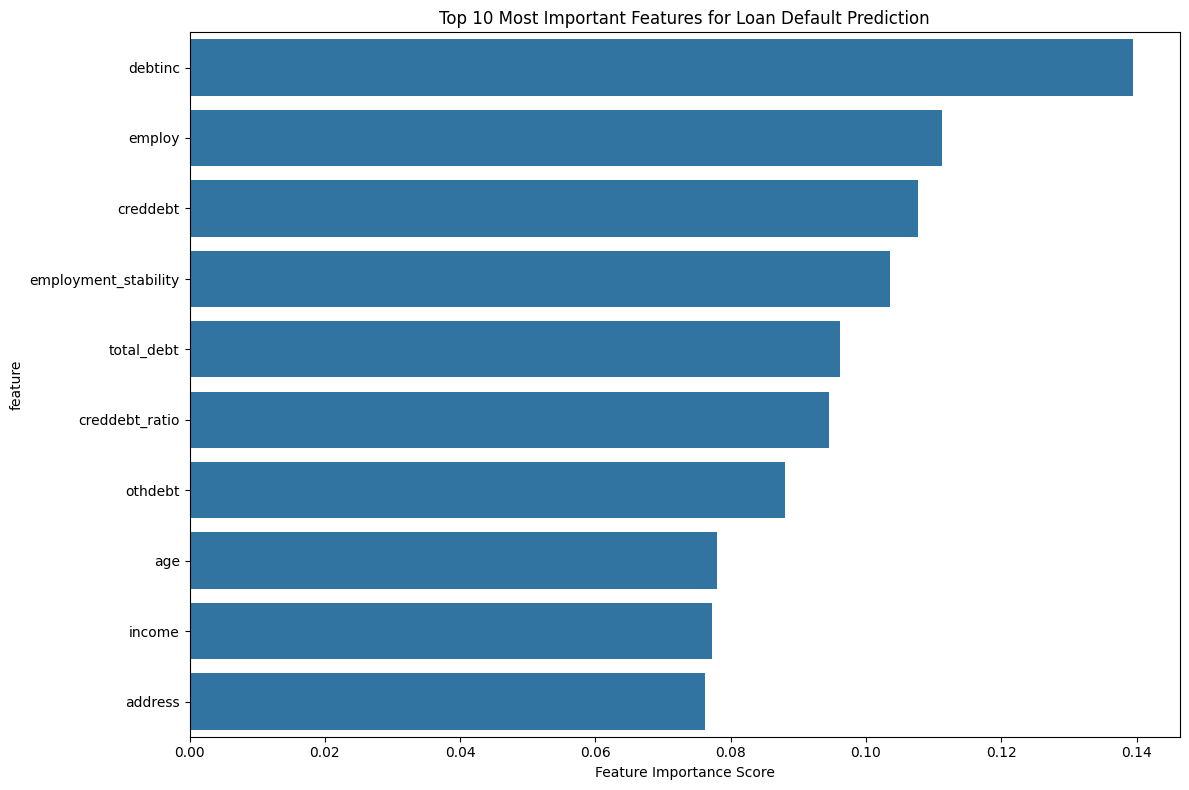

In [67]:
# Feature Importance Analysis
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Check importance of engineered features specifically
print("\n=== ENGINEERED FEATURES IMPORTANCE ===")
engineered_features = ['total_debt', 'employment_stability', 'creddebt_ratio']
engineered_importance = feature_importance_df[feature_importance_df['feature'].isin(engineered_features)]

if not engineered_importance.empty:
    print("Importance of engineered features:")
    for _, row in engineered_importance.iterrows():
        print(f"- {row['feature']}: {row['importance']*100:.2f}% importance")
else:
    print("No engineered features found in importance analysis")

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features for Loan Default Prediction')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()

# **Step4: Explainability and Fairness Analysis**
1. Use SHAP to explain model predictions and interpret the results.
2. Assess fairness by comparing model performance across demographic groups (e.g., age).


=== TASK 6: EXPLAINABILITY ANALYSIS ===
=== SHAP ANALYSIS ===


SHAP Summary Plot (showing impact on predicting default class):


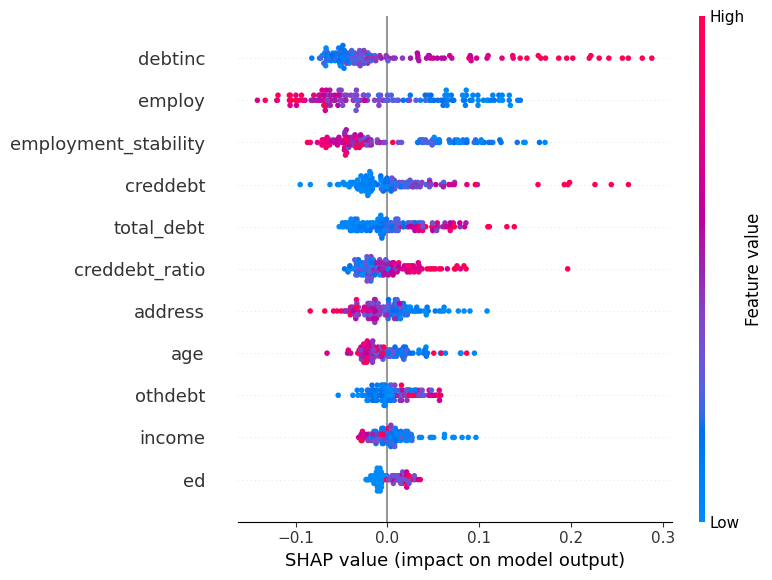

In [72]:
# Task 6: Explainability Analysis with SHAP and LIME
print("\n=== TASK 6: EXPLAINABILITY ANALYSIS ===")

# SHAP Analysis
print("=== SHAP ANALYSIS ===")

# Initialize JS for SHAP plots
shap.initjs()

# Create SHAP explainer
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_test)

# Summary plot
print("SHAP Summary Plot (showing impact on predicting default class):")
plt.figure(figsize=(10, 8))
# Corrected: Access SHAP values for class 1 across all samples and features
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()


=== TASK 7: FAIRNESS ANALYSIS ===
Sensitive Attribute: AGE

Fairness Metrics by Age Group:
                     count  actual_default_rate  predicted_default_rate  \
age_group                                                                 
Young (20-35)           81               0.3086                  0.2593   
Middle-aged (36-50)     53               0.1698                  0.1698   
Senior (51-65)           6               0.5000                  0.3333   

                     accuracy  
age_group                      
Young (20-35)        0.886792  
Middle-aged (36-50)  0.777778  
Senior (51-65)       0.500000  


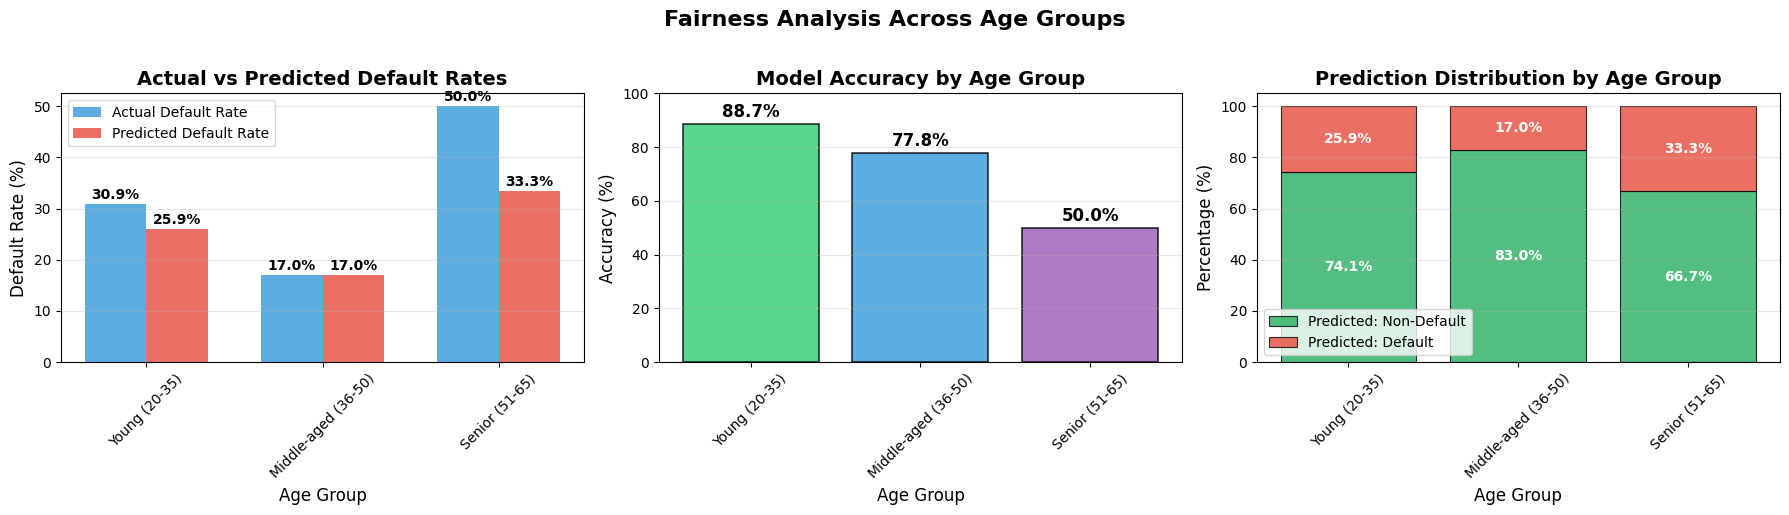


Statistical Test for Fairness (Chi-square):
Chi-square statistic: 1.8439
P-value: 0.3977
🟢 No significant association detected between age group and predictions

Key Disparity Metrics:
Maximum accuracy disparity: 38.68%
Maximum prediction rate disparity: 16.35%
🔴 FAIRNESS ASSESSMENT: Potential bias concerns detected


In [75]:
# Task 7: Fairness Analysis with Age as Sensitive Attribute
print("\n=== TASK 7: FAIRNESS ANALYSIS ===")
print("Sensitive Attribute: AGE")

# Create age groups for fairness analysis (using original age data)
X_test_copy = X_test.copy()
X_test_copy['age_original'] = data.loc[X_test.index, 'age']
X_test_copy['prediction'] = y_pred
X_test_copy['actual'] = y_test

# Define age groups for fairness analysis
X_test_copy['age_group'] = pd.cut(X_test_copy['age_original'],
                                 bins=[20, 35, 50, 65],
                                 labels=['Young (20-35)', 'Middle-aged (36-50)', 'Senior (51-65)'])

# Calculate fairness metrics by age group
fairness_metrics = X_test_copy.groupby('age_group').agg({
    'actual': ['count', 'mean'],
    'prediction': 'mean',
}).round(4)

fairness_metrics.columns = ['count', 'actual_default_rate', 'predicted_default_rate']

# Calculate accuracy by age group
accuracy_by_age = []
for group in X_test_copy['age_group'].unique():
    group_data = X_test_copy[X_test_copy['age_group'] == group]
    accuracy = accuracy_score(group_data['actual'], group_data['prediction'])
    accuracy_by_age.append(accuracy)

fairness_metrics['accuracy'] = accuracy_by_age

print("\nFairness Metrics by Age Group:")
print(fairness_metrics)

# Create a clean figure with exactly 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Fairness Analysis Across Age Groups', fontsize=16, fontweight='bold', y=1.02)

# Plot 1: Default rates by age group
ax1 = axes[0]
x_pos = np.arange(len(fairness_metrics.index))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, fairness_metrics['actual_default_rate'] * 100,
                width, label='Actual Default Rate', alpha=0.8, color='#3498db')
bars2 = ax1.bar(x_pos + width/2, fairness_metrics['predicted_default_rate'] * 100,
                width, label='Predicted Default Rate', alpha=0.8, color='#e74c3c')

ax1.set_xlabel('Age Group', fontsize=12)
ax1.set_ylabel('Default Rate (%)', fontsize=12)
ax1.set_title('Actual vs Predicted Default Rates', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(fairness_metrics.index, rotation=45)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Accuracy by age group
ax2 = axes[1]
colors = ['#2ecc71', '#3498db', '#9b59b6']
bars = ax2.bar(fairness_metrics.index, fairness_metrics['accuracy'] * 100,
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
ax2.set_xlabel('Age Group', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Model Accuracy by Age Group', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, color in zip(bars, colors):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 3: Distribution of predictions by age group
ax3 = axes[2]
prediction_distribution = pd.crosstab(X_test_copy['age_group'], X_test_copy['prediction'], normalize='index') * 100

# Create stacked bars manually
bottom = np.zeros(len(prediction_distribution))
colors_stack = ['#27ae60', '#e74c3c']
labels_stack = ['Predicted: Non-Default', 'Predicted: Default']

for i, (col, color) in enumerate(zip(prediction_distribution.columns, colors_stack)):
    values = prediction_distribution[col].values
    ax3.bar(prediction_distribution.index, values, bottom=bottom,
            color=color, alpha=0.8, edgecolor='black', linewidth=0.8, label=labels_stack[i])
    bottom += values

ax3.set_xlabel('Age Group', fontsize=12)
ax3.set_ylabel('Percentage (%)', fontsize=12)
ax3.set_title('Prediction Distribution by Age Group', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Add percentage labels in stacked bars
bottom = np.zeros(len(prediction_distribution))
for i, col in enumerate(prediction_distribution.columns):
    values = prediction_distribution[col].values
    for j, (age_group, value) in enumerate(zip(prediction_distribution.index, values)):
        if value > 5:
            ax3.text(j, bottom[j] + value/2, f'{value:.1f}%',
                    ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    bottom += values

plt.tight_layout()
plt.show()

# Statistical test for fairness
from scipy.stats import chi2_contingency

# Create contingency table for age group vs predictions
contingency_table = pd.crosstab(X_test_copy['age_group'], X_test_copy['prediction'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"\nStatistical Test for Fairness (Chi-square):")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("🔴 WARNING: Significant association detected between age group and predictions - Potential bias!")
else:
    print("🟢 No significant association detected between age group and predictions")

# Calculate and display key disparity metrics
print(f"\nKey Disparity Metrics:")
max_accuracy_disparity = (fairness_metrics['accuracy'].max() - fairness_metrics['accuracy'].min()) * 100
max_pred_disparity = (fairness_metrics['predicted_default_rate'].max() - fairness_metrics['predicted_default_rate'].min()) * 100

print(f"Maximum accuracy disparity: {max_accuracy_disparity:.2f}%")
print(f"Maximum prediction rate disparity: {max_pred_disparity:.2f}%")

# Simple fairness assessment
if p_value < 0.05 or max_accuracy_disparity > 10 or max_pred_disparity > 10:
    print("🔴 FAIRNESS ASSESSMENT: Potential bias concerns detected")
else:
    print("🟢 FAIRNESS ASSESSMENT: No major bias concerns detected")